In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler

sns.set(font_scale=1.5, style="darkgrid")

In [25]:
enz=pd.read_excel('201329_Julkunen_EachSample_vs_Enzyme.xlsx', sheet_name='Proteins', index_col=0)

In [26]:
enz.iloc[0,1:11]

Found in Sample Group: H1N1_Fin554_Without_pIC           High
Found in Sample Group: H1N1_Fin554_With_pIC              High
Found in Sample Group: H3N2_Udorn_Without_pIC            High
Found in Sample Group: H3N2_Udorn_With_pIC         Peak Found
Found in Sample Group: Enzyme                      Peak Found
Abundances (Grouped): H1N1_Fin554_Without_pIC     1.81342e+10
Abundances (Grouped): H1N1_Fin554_With_pIC        2.47047e+10
Abundances (Grouped): H3N2_Udorn_Without_pIC      2.14001e+08
Abundances (Grouped): H3N2_Udorn_With_pIC         1.09513e+08
Abundances (Grouped): Enzyme                      1.02949e+08
Name: C3W5S7, dtype: object

In [27]:
# check unique value
print(set([x for sublist in enz.iloc[:,1:5].values for x in sublist]))

print('we need to get the mapping back to nums here!')

{'Medium', 'High', 'Not Found', 'Peak Found'}
we need to get the mapping back to nums here!


In [85]:
def scale(colname, df, log=True):
    not_nans=~df[[colname]].isnull().iloc[:,0].values # remove NaNs
    ind=df.loc[not_nans].index
    m=MinMaxScaler()
    out=df.loc[ind].copy()
    if log:
        temp=df.loc[ind,colname].values
        mask=[True if x>0 else False for x in temp]
        out.loc[mask,colname]=np.log(np.asarray([value for value,to_keep in zip(temp, mask) if to_keep]))
        out.loc[mask,colname]=m.fit_transform(out.loc[mask,colname].values.reshape(-1,1))
    else:
        temp=[round(float(x), 4) for x in m.fit_transform(df.loc[ind,colname].values.reshape(-1,1)).reshape(-1)]
        out.loc[ind,colname]=temp
        
    return out.loc[:,colname]

def scale_and_filter(colname, df, top=1, log=True):
    '''
    returns sorted dict of protein names : abundances. 
    Log uses log transform and then scale to [0,1], else scale on raw data to [0,1]
    top is percent highest "quantified" values to return or count
    '''
    not_nans=~df[[colname]].isnull().iloc[:,0].values # remove NaNs
    ind=df.loc[not_nans].index
    m=MinMaxScaler()
    if log:
        temp=df.loc[ind,colname].values # remoev nans
        mask=[True if x>0 else False for x in temp] # we cannot find log(0)
        temp=np.log(np.asarray([value for value,to_keep in zip(temp, mask) if to_keep]))
        temp=[round(float(x), 4) for x in m.fit_transform(temp.reshape(-1,1))] # from scientific to floats + min-maxing
    else:
        temp=[round(float(x), 4) for x in m.fit_transform(df.loc[ind,colname].values.reshape(-1,1)).reshape(-1)]
    if isinstance(top, str):
        top=float(top[:-1]) # remove % chr
        val=np.percentile(temp, 100-top)
    else:
        # use count
        temp1 = sorted(temp, reverse=True)
        val = temp1[top-1]
    mask=[True if x>=val else False for x in temp]
    vals=[x for x in temp if x>=val]
    return dict(sorted({k:v for k,v in zip(ind[mask], vals)}.items(), key=lambda item: item[1], reverse=True))




In [86]:
enz.columns

Index(['Description', 'Found in Sample Group: H1N1_Fin554_Without_pIC',
       'Found in Sample Group: H1N1_Fin554_With_pIC',
       'Found in Sample Group: H3N2_Udorn_Without_pIC',
       'Found in Sample Group: H3N2_Udorn_With_pIC',
       'Found in Sample Group: Enzyme',
       'Abundances (Grouped): H1N1_Fin554_Without_pIC',
       'Abundances (Grouped): H1N1_Fin554_With_pIC',
       'Abundances (Grouped): H3N2_Udorn_Without_pIC',
       'Abundances (Grouped): H3N2_Udorn_With_pIC',
       'Abundances (Grouped): Enzyme',
       'Abundance Ratio: (H1N1_Fin554_Without_pIC) / (Enzyme)',
       'Abundance Ratio: (H1N1_Fin554_With_pIC) / (Enzyme)',
       'Abundance Ratio: (H3N2_Udorn_Without_pIC) / (Enzyme)',
       'Abundance Ratio: (H3N2_Udorn_With_pIC) / (Enzyme)',
       'Abundance Ratio (log2): (H1N1_Fin554_Without_pIC) / (Enzyme)',
       'Abundance Ratio (log2): (H1N1_Fin554_With_pIC) / (Enzyme)',
       'Abundance Ratio (log2): (H3N2_Udorn_Without_pIC) / (Enzyme)',
       'Abund

In [87]:
x='Abundances (Grouped): H1N1_Fin554_Without_pIC'
scale(x, enz, log=True)

Accession
C3W5S7    1.000000
P11498    0.846032
O00571    0.946316
P04264    0.856348
P0DMV8    0.877547
            ...   
Q7L266    0.494976
Q63ZY3    0.389439
P20042    0.578163
Q12774    0.521523
O94986    0.548777
Name: Abundances (Grouped): H1N1_Fin554_Without_pIC, Length: 1205, dtype: float64

In [88]:
x='Abundances (Grouped): H1N1_Fin554_Without_pIC'
scale_and_filter(x, enz, log=False, top=10)

{'C3W5S7': 1.0,
 'O00571': 0.4059,
 'P37802': 0.1359,
 'Q6P2H3': 0.1355,
 'P0DMV8': 0.1279,
 'Q14247': 0.1217,
 'Q15233': 0.1131,
 'Q96KR1': 0.113,
 'Q8NC51': 0.1097,
 'O60814': 0.1004}

In [89]:
scale_and_filter(x, enz, log=True, top=10)

{'C3W5S7': 1.0,
 'O00571': 0.9463,
 'P37802': 0.8812,
 'Q6P2H3': 0.881,
 'P0DMV8': 0.8775,
 'Q14247': 0.8746,
 'Q15233': 0.8703,
 'Q96KR1': 0.8702,
 'Q8NC51': 0.8684,
 'O60814': 0.8631}

In [90]:
scale_and_filter(x, enz, log=True, top='1%')

{'C3W5S7': 1.0,
 'O00571': 0.9463,
 'P37802': 0.8812,
 'Q6P2H3': 0.881,
 'P0DMV8': 0.8775,
 'Q14247': 0.8746,
 'Q15233': 0.8703,
 'Q96KR1': 0.8702,
 'Q8NC51': 0.8684,
 'O60814': 0.8631,
 'Q6PKG0': 0.8612,
 'P04264': 0.8563,
 'P23588': 0.8511}

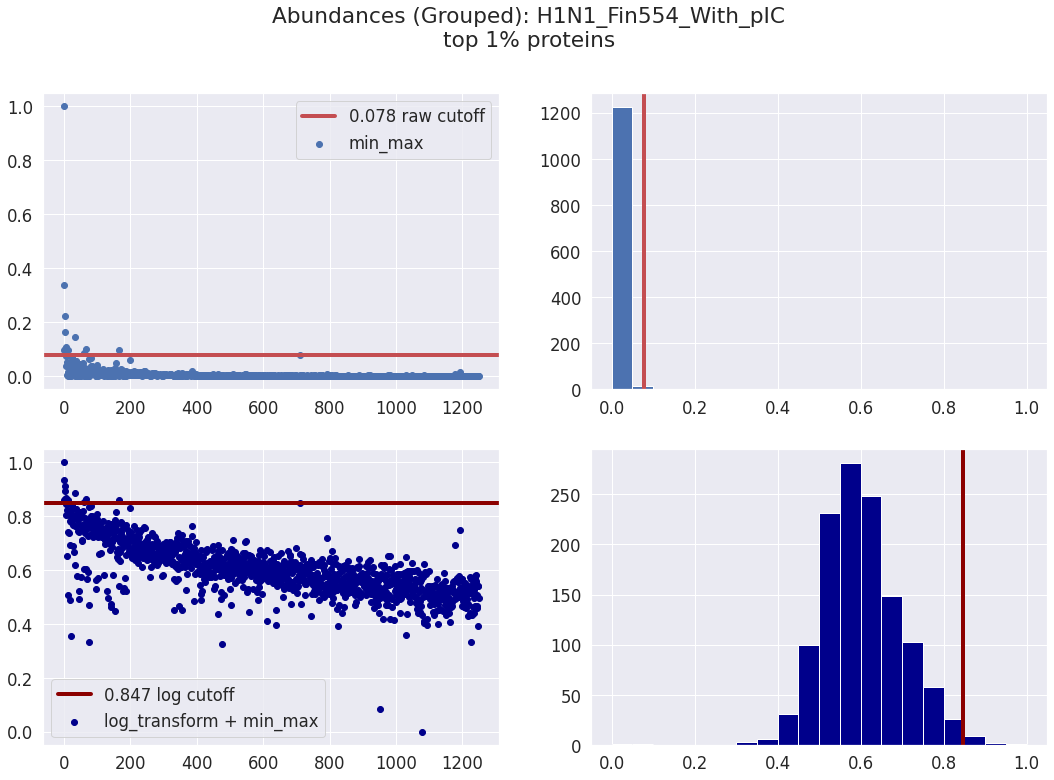

In [123]:
w=4
top='1%' # top n% values
colname='Abundances (Grouped): H1N1_Fin554_With_pIC'
# 'Abundances (Grouped): H1N1_Fin554_With_pIC'
# 'Abundances (Grouped): H1N1_Fin554_Without_pIC'
# 'Abundances (Grouped): H3N2_Udorn_Without_pIC'
# 'Abundances (Grouped): H3N2_Udorn_With_pIC'
# 'Abundances (Grouped): Enzyme'

def plot(colname, top, df):

    temp_log=scale(colname=colname, df=df, log=True)
    cutoff_log=list(scale_and_filter(colname, df, top=top, log=True).values())[-1]
    temp=scale(colname, df=df, log=False)
    cutoff=list(scale_and_filter(colname=colname, df=df, top=top, log=False).values())[-1]

    fig, ax=plt.subplots(nrows=2,ncols=2, figsize=(18,12))
    ax[0,0].scatter(x=range(len(temp)),y=temp, label='min_max')
        
    ax[0,0].axhline(cutoff, color='r', linewidth=w, label=f'{round(cutoff,3)} raw cutoff')


    ax[0,0].legend()
    ax[0,1].hist(temp, bins=20)
    ax[0,1].axvline(cutoff, color='r', linewidth=w)


    ax[1,0].scatter(x=range(len(temp_log)), y=temp_log, label='log_transform + min_max', color='darkblue')
    ax[1,0].axhline(cutoff_log, color='darkred', linewidth=w, label=f'{round(cutoff_log,3)} log cutoff')

    ax[1,0].legend()
    ax[1,1].hist(temp_log, bins=20, color='darkblue')
    ax[1,1].axvline(cutoff_log, color='darkred', linewidth=w)
    
    #fig.legend(loc='upper left' , bbox_to_anchor=[-0.05, 1])
    fig.suptitle(colname+'\n'+f'top {top} proteins')
    return fig

f=plot(colname=colname, top=top, df=enz)

In [124]:
temp=[]
colnames=['Abundances (Grouped): H3N2_Udorn_Without_pIC', 
          'Abundances (Grouped): H3N2_Udorn_With_pIC',
          'Abundances (Grouped): H1N1_Fin554_Without_pIC',
          'Abundances (Grouped): H1N1_Fin554_With_pIC',          
          'Abundances (Grouped): Enzyme']
for colname in colnames:
    df1=scale(colname=colname, df=enz, log=True)
    temp.append(df1)

df1=pd.concat(temp, axis=1)

In [125]:
df1.dropna(inplace=True)

df2=pd.DataFrame(index=df1.index)
df2['h3n2_without_pIC/enzyme']=df1['Abundances (Grouped): H3N2_Udorn_Without_pIC']/df1['Abundances (Grouped): Enzyme']
df2['h3n2_with_pIC/enzyme']=df1['Abundances (Grouped): H3N2_Udorn_With_pIC']/df1['Abundances (Grouped): Enzyme']
df2['h1n1_without_pIC/enzyme']=df1['Abundances (Grouped): H1N1_Fin554_Without_pIC']/df1['Abundances (Grouped): Enzyme']
df2['h1n1_with_pIC/enzyme']=df1['Abundances (Grouped): H1N1_Fin554_With_pIC']/df1['Abundances (Grouped): Enzyme']

# log-fold change. delta=1, means one power of e, since nat.log
df2['h3n2_without_pIC-with_pIC']=df2['h3n2_without_pIC/enzyme']-df2['h3n2_with_pIC/enzyme']
df2['h1n1_without_pIC-with_pIC']=df2['h1n1_without_pIC/enzyme']-df2['h1n1_with_pIC/enzyme']
df2['h1n1_with_pIC-h3n2_with_pIC']=df2['h1n1_with_pIC/enzyme']-df2['h3n2_with_pIC/enzyme']

# % change using either withotu pIC to norm, or h1n1
df2['h3n2_without_pIC-with_pIC %']=100*(df2['h3n2_without_pIC/enzyme']-df2['h3n2_with_pIC/enzyme'])/df2['h3n2_without_pIC/enzyme'].abs()
df2['h1n1_without_pIC-with_pIC %']=100*(df2['h1n1_without_pIC/enzyme']-df2['h1n1_with_pIC/enzyme'])/df2['h1n1_without_pIC/enzyme'].abs()
df2['h1n1_with_pIC-h3n2_with_pIC %']=100*(df2['h1n1_with_pIC/enzyme']-df2['h3n2_with_pIC/enzyme'])/df2['h1n1_with_pIC/enzyme'].abs()


In [126]:
df2.head(n=20)

,h3n2_without_pIC/enzyme,h3n2_with_pIC/enzyme,h1n1_without_pIC/enzyme,h1n1_with_pIC/enzyme,h3n2_without_pIC-with_pIC,h1n1_without_pIC-with_pIC,h1n1_with_pIC-h3n2_with_pIC,h3n2_without_pIC-with_pIC %,h1n1_without_pIC-with_pIC %,h1n1_with_pIC-h3n2_with_pIC %
C3W5S7,0.989108,0.997235,1.292159,1.292159,-0.008127,0.000000,0.294923,-0.821648,0.000000,22.824085
P11498,1.207117,1.015008,1.021260,1.037152,0.192110,-0.015893,0.022144,15.914732,-1.556179,2.135100
O00571,1.055062,1.019261,1.330713,1.315211,0.035801,0.015502,0.295950,3.393243,1.164932,22.502066
P04264,1.158456,1.090067,1.090837,1.099582,0.068388,-0.008745,0.009515,5.903402,-0.801642,0.865292
P0DMV8,1.271884,0.924104,1.359971,1.382722,0.347780,-0.022751,0.458618,27.343677,-1.672916,33.167769
Q15233,1.246491,1.121620,1.248706,1.306352,0.124871,-0.057646,0.184733,10.017834,-4.616492,14.141105
P48634,0.899541,0.985908,0.964972,0.963412,-0.086367,0.001560,-0.022496,-9.601283,0.161620,-2.335032
Q8IWZ3-6,0.722779,0.957791,1.141127,1.137771,-0.235012,0.003356,0.179980,-32.515086,0.294109,15.818651
Q96KR1,1.369101,1.063406,1.419818,1.413313,0.305695,0.006505,0.349907,22.328141,0.458174,24.757900
P35527,1.193603,1.140902,1.139936,1.147227,0.052701,-0.007291,0.006325,4.415298,-0.639589,0.551345


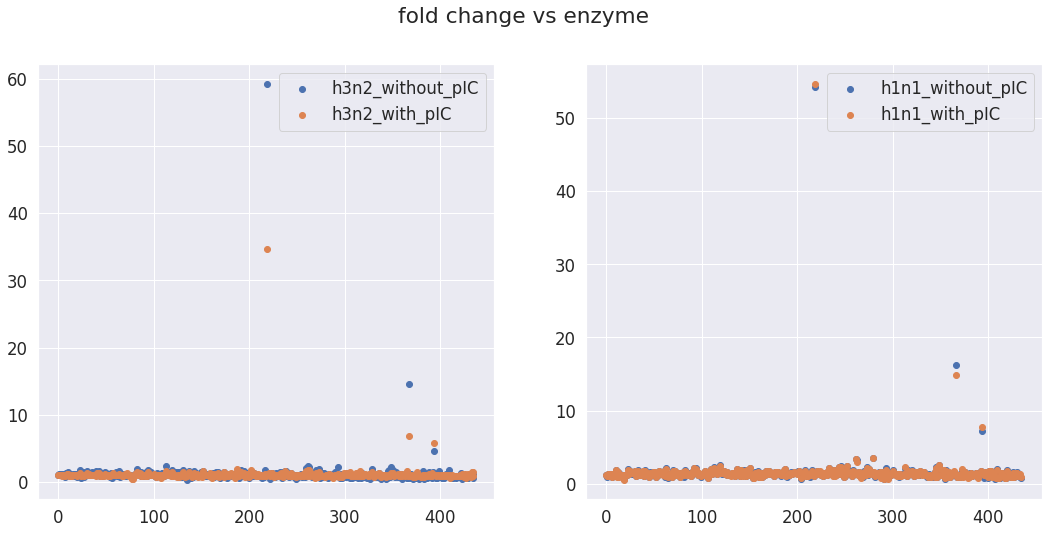

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8))

ax1.scatter(x=range(len(df2)), y=df2.iloc[:,0], label='h3n2_without_pIC')
ax1.scatter(x=range(len(df2)), y=df2.iloc[:,1], label='h3n2_with_pIC')
ax2.scatter(x=range(len(df2)), y=df2.iloc[:,2], label='h1n1_without_pIC')
ax2.scatter(x=range(len(df2)), y=df2.iloc[:,3], label='h1n1_with_pIC')

ax1.legend()
ax2.legend()
plt.suptitle('fold change vs enzyme')
plt.show()

In [128]:
df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC', ascending=False)[:3]

,h3n2_without_pIC/enzyme,h3n2_with_pIC/enzyme,h1n1_without_pIC/enzyme,h1n1_with_pIC/enzyme,h3n2_without_pIC-with_pIC,h1n1_without_pIC-with_pIC,h1n1_with_pIC-h3n2_with_pIC,h3n2_without_pIC-with_pIC %,h1n1_without_pIC-with_pIC %,h1n1_with_pIC-h3n2_with_pIC %
Q14978,59.164831,34.592513,54.217028,54.560030,24.572318,-0.343002,19.967517,41.531966,-0.632646,36.597334
Q15648,14.523225,6.817917,16.288113,14.863095,7.705309,1.425018,8.045178,53.055080,8.748822,54.128554
Q9NUQ6-2,1.252669,0.689179,3.616725,3.538804,0.563490,0.077921,2.849625,44.983174,2.154467,80.525097


In [129]:
pd.set_option('display.max_colwidth', 120)
enz.loc[sorted(df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC', ascending=False)[:3].index, reverse=True),'Description'].to_frame()

,Description
Accession,
Q9NUQ6-2,Isoform 2 of SPATS2-like protein OS=Homo sapiens OX=9606 GN=SPATS2L
Q15648,Mediator of RNA polymerase II transcription subunit 1 OS=Homo sapiens OX=9606 GN=MED1 PE=1 SV=4
Q14978,Nucleolar and coiled-body phosphoprotein 1 OS=Homo sapiens OX=9606 GN=NOLC1 PE=1 SV=2


['O75122', 'O75128', 'O94913', 'O95232', 'P03495', 'P05204', 'P15880', 'P16402', 'P20930', 'P55196', 'P62826', 'P78347', 'Q13148', 'Q14978', 'Q15648', 'Q5VT06', 'Q7Z5K2', 'Q96AG4', 'Q96D09', 'Q9BTD8', 'Q9NUQ6-2']


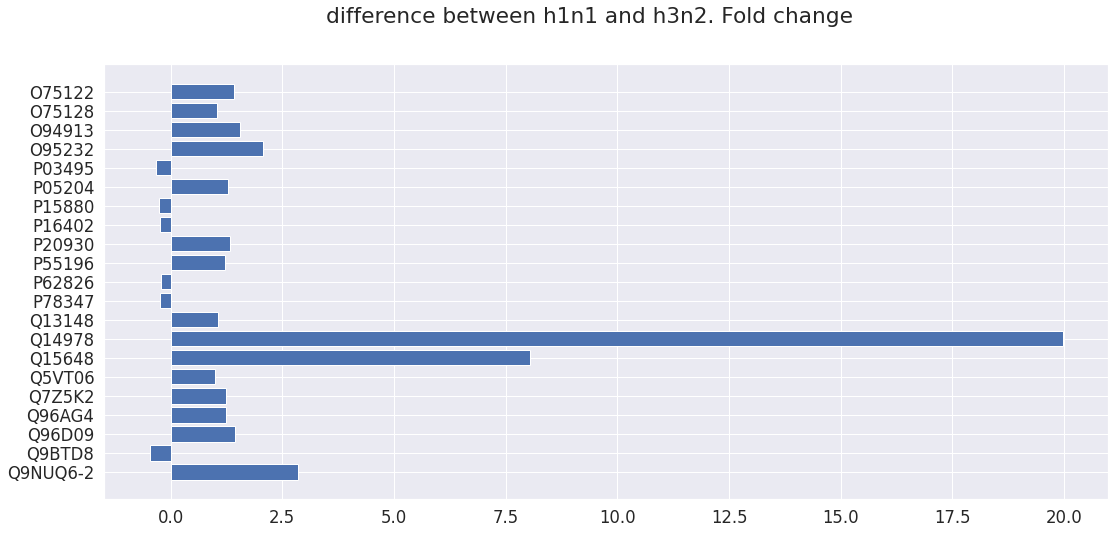

In [130]:
# fold difference, abs > 1 and negative smaller than 0.2

temp1=df2[df2['h1n1_with_pIC-h3n2_with_pIC'].abs()>1].loc[:,'h1n1_with_pIC-h3n2_with_pIC']
temp2=df2[df2['h1n1_with_pIC-h3n2_with_pIC']< -0.2 ].loc[:,'h1n1_with_pIC-h3n2_with_pIC']
temp=pd.concat([temp1, temp2], axis=0)


fig, ax = plt.subplots(1,1, figsize=(18,8))

ax.barh(y=temp.sort_index(ascending=False).index, width=temp.sort_index(ascending=False).values)

fig.suptitle('difference between h1n1 and h3n2. Fold change')
fig.show()
print(sorted(temp.index, reverse=False))

In [54]:
pd.set_option('display.max_colwidth', 120)
enz.loc[sorted(temp.index, reverse=True),'Description'].to_frame()

,Description
Accession,
Q9NUQ6-2,Isoform 2 of SPATS2-like protein OS=Homo sapiens OX=9606 GN=SPATS2L
Q9BTD8,RNA-binding protein 42 OS=Homo sapiens OX=9606 GN=RBM42 PE=1 SV=1
Q96D09,G-protein coupled receptor-associated sorting protein 2 OS=Homo sapiens OX=9606 GN=GPRASP2 PE=1 SV=1
Q96AG4,Leucine-rich repeat-containing protein 59 OS=Homo sapiens OX=9606 GN=LRRC59 PE=1 SV=1
Q7Z5K2,Wings apart-like protein homolog OS=Homo sapiens OX=9606 GN=WAPL PE=1 SV=1
Q5VT06,Centrosome-associated protein 350 OS=Homo sapiens OX=9606 GN=CEP350 PE=1 SV=1
Q15648,Mediator of RNA polymerase II transcription subunit 1 OS=Homo sapiens OX=9606 GN=MED1 PE=1 SV=4
Q14978,Nucleolar and coiled-body phosphoprotein 1 OS=Homo sapiens OX=9606 GN=NOLC1 PE=1 SV=2
Q13148,TAR DNA-binding protein 43 OS=Homo sapiens OX=9606 GN=TARDBP PE=1 SV=1


['O43395', 'O75122', 'O75128', 'P20930', 'P49959', 'P55196', 'Q12929', 'Q15648', 'Q6PJT7', 'Q7Z5K2', 'Q7Z7F0', 'Q93052', 'Q96D09', 'Q96HC4', 'Q9BTD8', 'Q9NUQ6-2', 'Q9Y265']


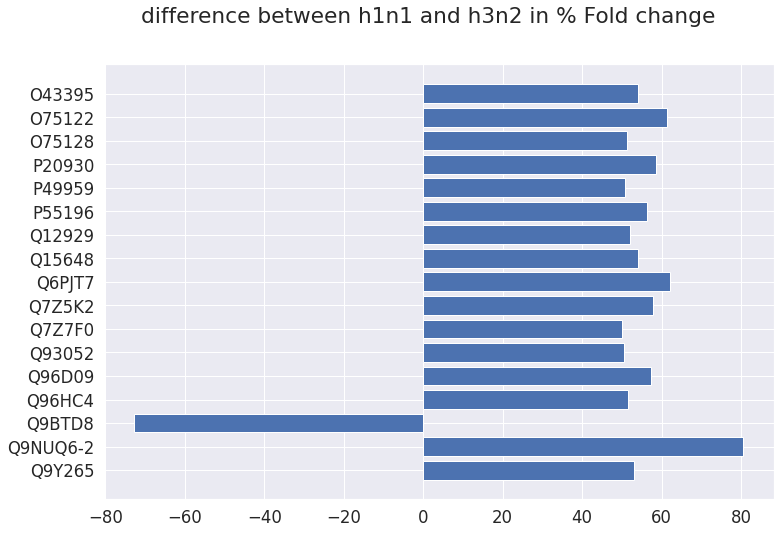

In [131]:
# % change, more than 50% abs

temp=df2[df2['h1n1_with_pIC-h3n2_with_pIC %'].abs()>50].loc[:,'h1n1_with_pIC-h3n2_with_pIC %']

fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.barh(y=temp.sort_index(ascending=False).index, width=temp.sort_index(ascending=False).values)

fig.suptitle('difference between h1n1 and h3n2 in % Fold change')
fig.show()
print(sorted(temp.index, reverse=False))

# protein abundance is > in h1n1

In [58]:
pd.set_option('display.max_colwidth', 120)
enz.loc[sorted(temp.index, reverse=False),'Description'].to_frame()

,Description
Accession,
O43395,U4/U6 small nuclear ribonucleoprotein Prp3 OS=Homo sapiens OX=9606 GN=PRPF3 PE=1 SV=2
O75122,CLIP-associating protein 2 OS=Homo sapiens OX=9606 GN=CLASP2 PE=1 SV=3
O75128,Protein cordon-bleu OS=Homo sapiens OX=9606 GN=COBL PE=1 SV=2
P20930,Filaggrin OS=Homo sapiens OX=9606 GN=FLG PE=1 SV=3
P49959,Double-strand break repair protein MRE11 OS=Homo sapiens OX=9606 GN=MRE11 PE=1 SV=3
P55196,Afadin OS=Homo sapiens OX=9606 GN=AFDN PE=1 SV=3
Q12929,Epidermal growth factor receptor kinase substrate 8 OS=Homo sapiens OX=9606 GN=EPS8 PE=1 SV=1
Q15648,Mediator of RNA polymerase II transcription subunit 1 OS=Homo sapiens OX=9606 GN=MED1 PE=1 SV=4
Q6PJT7,Zinc finger CCCH domain-containing protein 14 OS=Homo sapiens OX=9606 GN=ZC3H14 PE=1 SV=1


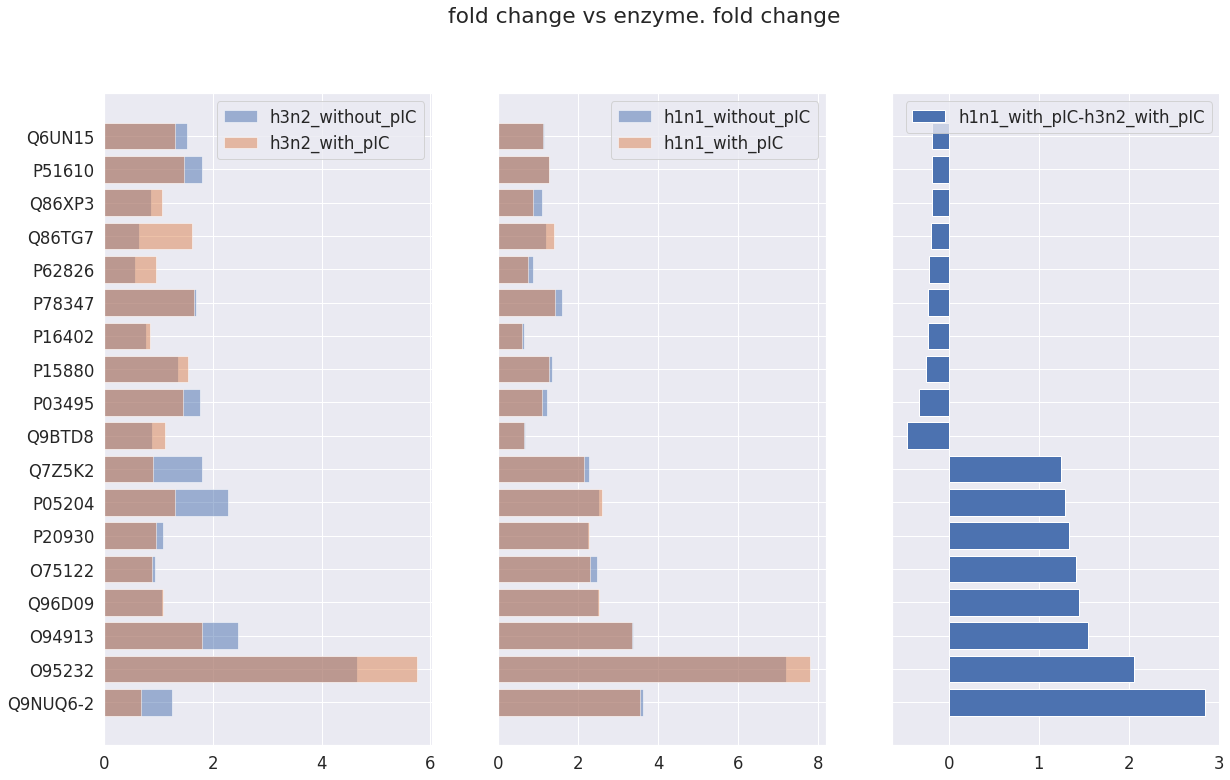

['O75122', 'O94913', 'O95232', 'P03495', 'P05204', 'P15880', 'P16402', 'P20930', 'P51610', 'P62826', 'P78347', 'Q6UN15', 'Q7Z5K2', 'Q86TG7', 'Q86XP3', 'Q96D09', 'Q9BTD8', 'Q9NUQ6-2']


In [132]:
temp1=df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC', ascending=False).iloc[2:10,:]
temp2=df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC', ascending=True).iloc[:10,:]
temp=pd.concat([temp1, temp2], axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,12), sharey=True)

ax1.barh(y=temp.index, width=temp.iloc[:,0], label='h3n2_without_pIC',alpha=0.5)
ax1.barh(y=temp.index, width=temp.iloc[:,1], label='h3n2_with_pIC',alpha=0.5)
ax2.barh(y=temp.index, width=temp.iloc[:,2], label='h1n1_without_pIC',alpha=0.5)
ax2.barh(y=temp.index, width=temp.iloc[:,3], label='h1n1_with_pIC',alpha=0.5)

# lowest and highest top 10
ax3.barh(y=temp.index, width=temp.loc[:,'h1n1_with_pIC-h3n2_with_pIC'], label='h1n1_with_pIC-h3n2_with_pIC')

ax1.legend()
ax2.legend()
ax3.legend()
plt.suptitle('fold change vs enzyme. fold change')
plt.show()
print(sorted(temp.index, reverse=False))

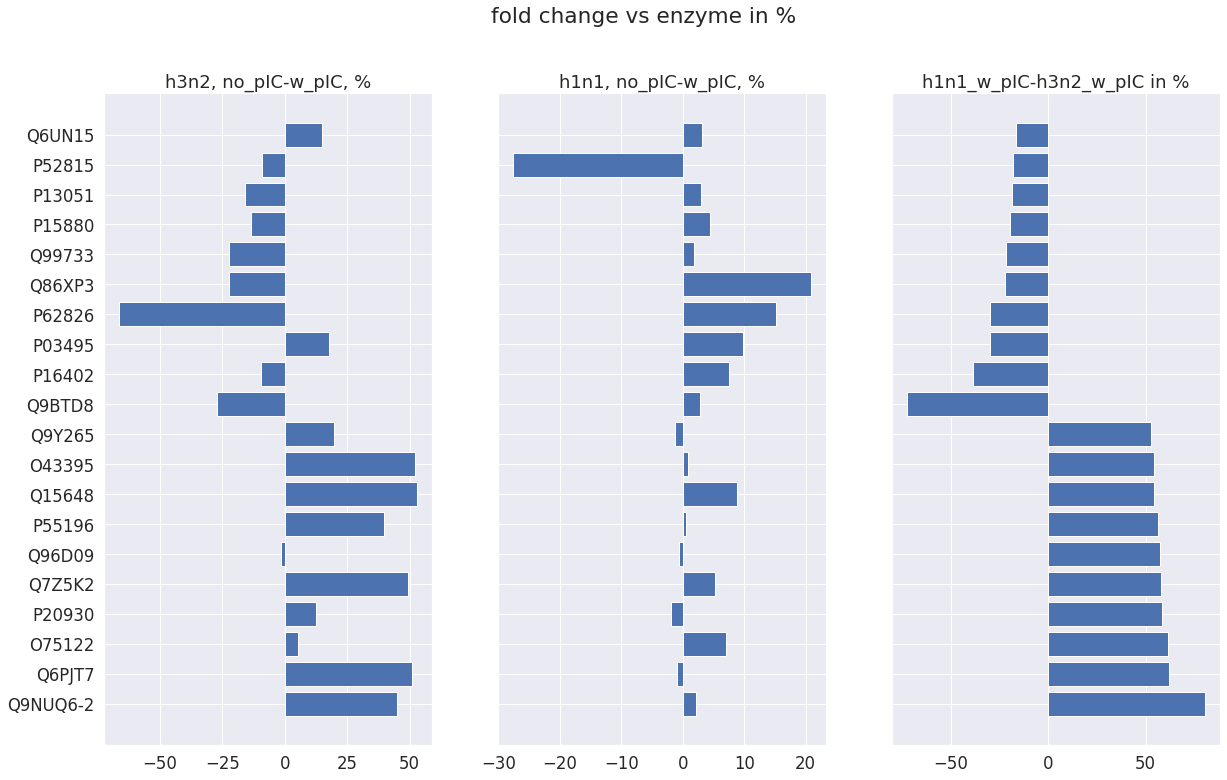

['O43395', 'O75122', 'P03495', 'P13051', 'P15880', 'P16402', 'P20930', 'P52815', 'P55196', 'P62826', 'Q15648', 'Q6PJT7', 'Q6UN15', 'Q7Z5K2', 'Q86XP3', 'Q96D09', 'Q99733', 'Q9BTD8', 'Q9NUQ6-2', 'Q9Y265']


In [133]:
temp1=df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC %', ascending=False).iloc[:10,:]
temp2=df2.sort_values(by='h1n1_with_pIC-h3n2_with_pIC %', ascending=True).iloc[:10,:]
temp=pd.concat([temp1, temp2], axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,12), sharey=True)

ax1.barh(y=temp.index, width=temp.loc[:,'h3n2_without_pIC-with_pIC %'])
ax1.title.set_text('h3n2, no_pIC-w_pIC, %')
ax2.barh(y=temp.index, width=temp.loc[:,'h1n1_without_pIC-with_pIC %'])
ax2.title.set_text('h1n1, no_pIC-w_pIC, %')
ax3.barh(y=temp.index, width=temp.loc[:,'h1n1_with_pIC-h3n2_with_pIC %'])
ax3.title.set_text('h1n1_w_pIC-h3n2_w_pIC in %')

plt.suptitle('fold change vs enzyme in %')
plt.show()
print(sorted(temp.index, reverse=False))

In [66]:
df2.head()

,h3n2_without_pIC/enzyme,h3n2_with_pIC/enzyme,h1n1_without_pIC/enzyme,h1n1_with_pIC/enzyme,h3n2_without_pIC-with_pIC,h1n1_without_pIC-with_pIC,h1n1_with_pIC-h3n2_with_pIC,h3n2_without_pIC-with_pIC %,h1n1_without_pIC-with_pIC %,h1n1_with_pIC-h3n2_with_pIC %
C3W5S7,0.989108,0.997235,1.292159,1.292159,-0.008127,0.000000,0.294923,-0.821648,0.000000,22.824085
P11498,1.207117,1.015008,1.021260,1.037152,0.192110,-0.015893,0.022144,15.914732,-1.556179,2.135100
O00571,1.055062,1.019261,1.330713,1.315211,0.035801,0.015502,0.295950,3.393243,1.164932,22.502066
P04264,1.158456,1.090067,1.090837,1.099582,0.068388,-0.008745,0.009515,5.903402,-0.801642,0.865292
P0DMV8,1.271884,0.924104,1.359971,1.382722,0.347780,-0.022751,0.458618,27.343677,-1.672916,33.167769


In [65]:
pd.set_option('display.max_colwidth', 120)
enz.loc[sorted(temp.index, reverse=False),'Description'].to_frame()

,Description
Accession,
O43395,U4/U6 small nuclear ribonucleoprotein Prp3 OS=Homo sapiens OX=9606 GN=PRPF3 PE=1 SV=2
O75122,CLIP-associating protein 2 OS=Homo sapiens OX=9606 GN=CLASP2 PE=1 SV=3
P03495,Non-structural protein 1 OS=Influenza A virus (strain A/Udorn/307/1972 H3N2) OX=381517 GN=NS PE=1 SV=1
P13051,Uracil-DNA glycosylase OS=Homo sapiens OX=9606 GN=UNG PE=1 SV=2
P15880,40S ribosomal protein S2 OS=Homo sapiens OX=9606 GN=RPS2 PE=1 SV=2
P16402,Histone H1.3 OS=Homo sapiens OX=9606 GN=H1-3 PE=1 SV=2
P20930,Filaggrin OS=Homo sapiens OX=9606 GN=FLG PE=1 SV=3
P52815,"39S ribosomal protein L12, mitochondrial OS=Homo sapiens OX=9606 GN=MRPL12 PE=1 SV=2"
P55196,Afadin OS=Homo sapiens OX=9606 GN=AFDN PE=1 SV=3
